In [18]:
import os
import sys
os.chdir('/home/ubuntu/speech2speech')
sys.path.append(os.path.abspath(os.path.dirname('/home/ubuntu/speech2speech') + '/..'))

import matplotlib.pyplot as plt
import math
import pandas as pd
from torchviz import make_dot, make_dot_from_trace
import random
from torchsummary import summary
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch
import umap
from six.moves import xrange
from scipy.signal import savgol_filter
import pathlib
import librosa.display
import librosa
import numpy as np
import json
import argparse
from tqdm import tqdm

from speech2speech.data_preprocessing.load_data import *
from speech2speech.models.model import Model
from speech2speech.models.training_utils import *
from torchsummary import summary

In [2]:
!ls

FAILED001.test_num_embeddings300_spectrogram_db_lr1em3
README.md
__init__.py
checkpoints
data
notebooks
output
plots
scripts
speech2speech
test_num_embeddings256_spectrogram_db_lr1em4
test_num_embeddings300_spectrogram_db_lr1em3
test_num_embeddings300_spectrogram_db_lr1em4
test_num_embeddings_500


In [19]:
device = torch.device("cuda")

In [20]:
checkpoint_dir = os.path.join('/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_db_lr1em4/', 'checkpoints')

In [21]:
def get_latest_checkpoint(checkpoint_dir):
    '''
Return the latest checkpoint index and file in user provided directory
    '''
    all_files = {}
    file_list = glob.glob(os.path.join(checkpoint_dir, 'checkpoint*'))
    latest_file = max(file_list, key=os.path.getctime)
    
    return latest_file

In [22]:
get_latest_checkpoint(checkpoint_dir)

'/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_db_lr1em4/checkpoints/checkpoint_state_dict_20'

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
spectrogram_dir= '/home/ubuntu/speech2speech/data/interim/spectogram_array_path_trim_30db_ntft_512'

In [25]:
num_hiddens = 768
num_residual_layers = 2
num_residual_hiddens = 32
num_embeddings = 300
embedding_dim = 64
commitment_cost = 0.25
files_np = list(glob.glob(os.path.join(spectrogram_dir, '*.*')))
speaker_dic = speaker_id_dic(files_np)
speaker_id = '260'
speaker_embedding_dim = 20
decay = 0
learning_rate = 1e-4
batch_size  = 10
time_length = 100
num_epochs = 20

In [26]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, speaker_dic, speaker_id, speaker_embedding_dim, decay, device).to(device)

In [27]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [28]:
def load_checkpoint(model, optimizer, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [29]:
tensordataset = spectrograms_to_torch_dataset(files_np, time_length)

In [30]:
train_dataset, val_dataset, test_dataset = split_dataset(
    tensordataset, 0.8, 0.1)

In [31]:
training_loader, validation_loader = train_val_data_loaders(train_dataset, val_dataset, batch_size)

In [100]:
model, optimizer, start_epoch = load_checkpoint(model, optimizer, get_latest_checkpoint(checkpoint_dir))

=> loading checkpoint '/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_db_lr1em4/checkpoints/checkpoint_state_dict_20'
=> loaded checkpoint '/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_db_lr1em4/checkpoints/checkpoint_state_dict_20' (epoch 20)


In [101]:
model

Model(
  (_encoder): Encoder(
    (_conv_1): Conv1d(257, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (_conv_2): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (_conv_3): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(2,))
    (_conv_4): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (_conv_5): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv1d(768, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv1d(32, 768, kernel_size=(1,), stride=(1,), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv1d(768, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (2): ReLU(

In [33]:
(data, _) = next(iter(training_loader))
data = data.to(device)

vq_loss, data_recon, perplexity = model(data)

In [36]:
librosa.griffinlim?

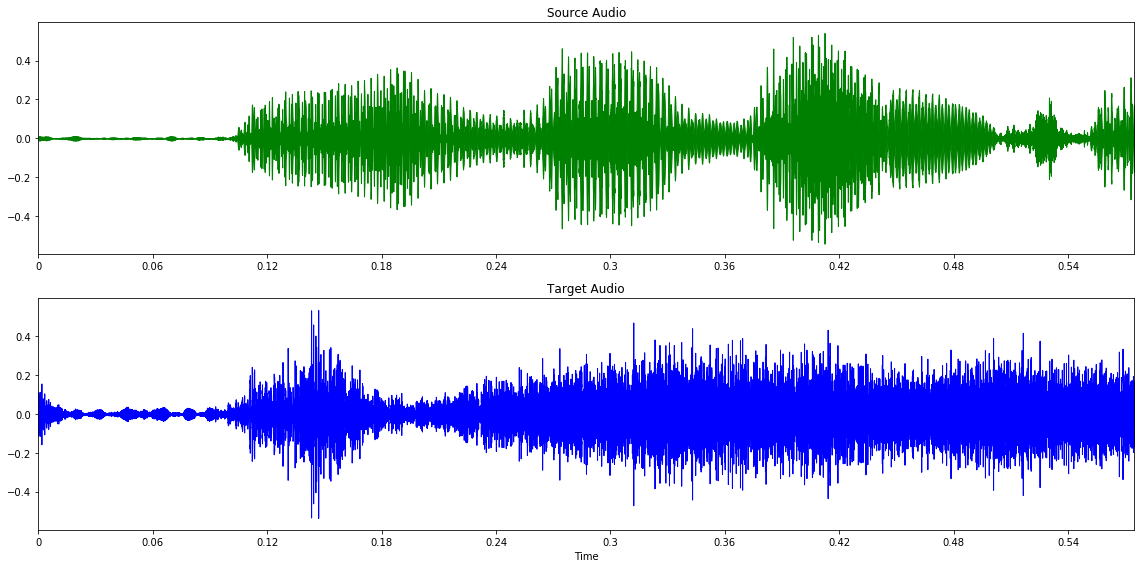

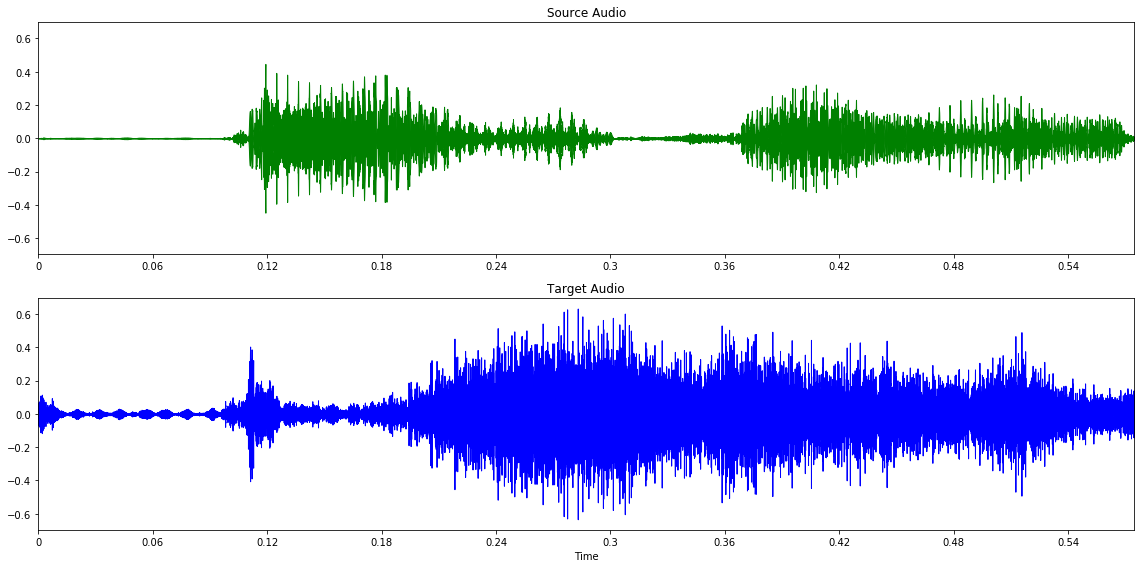

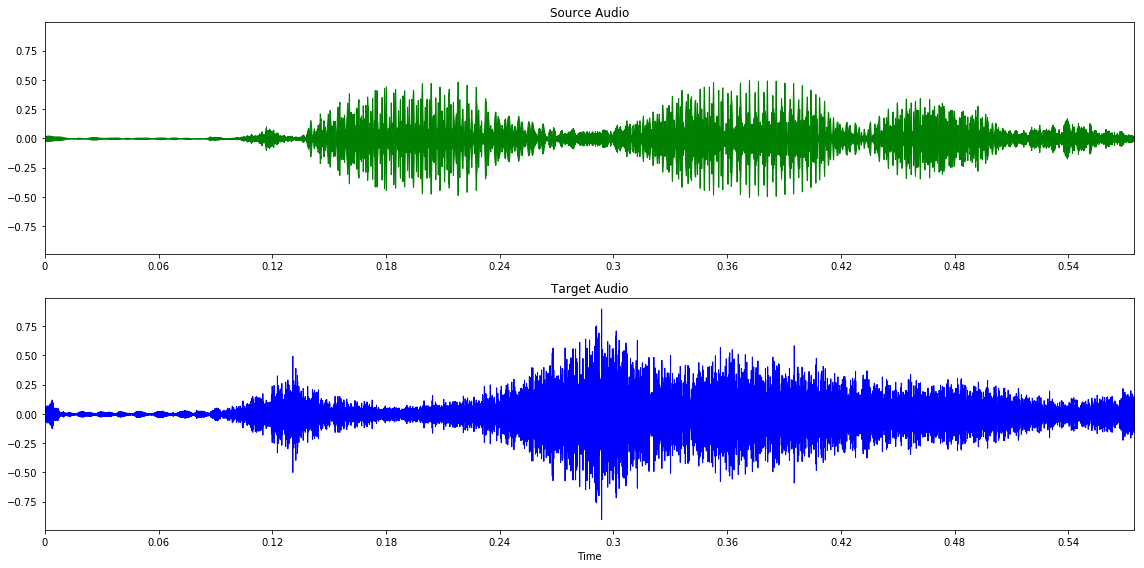

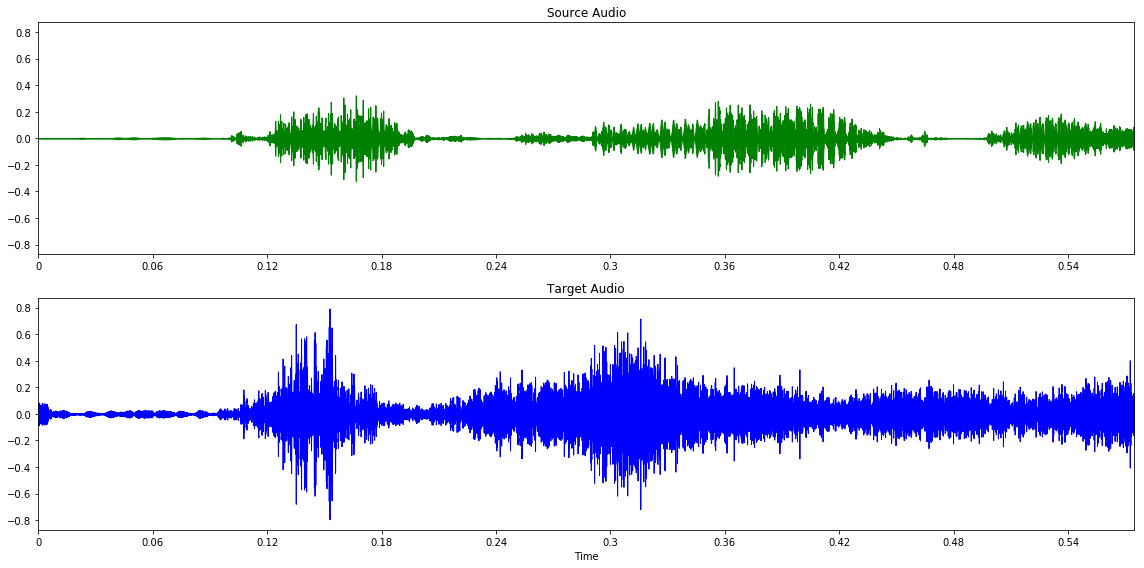

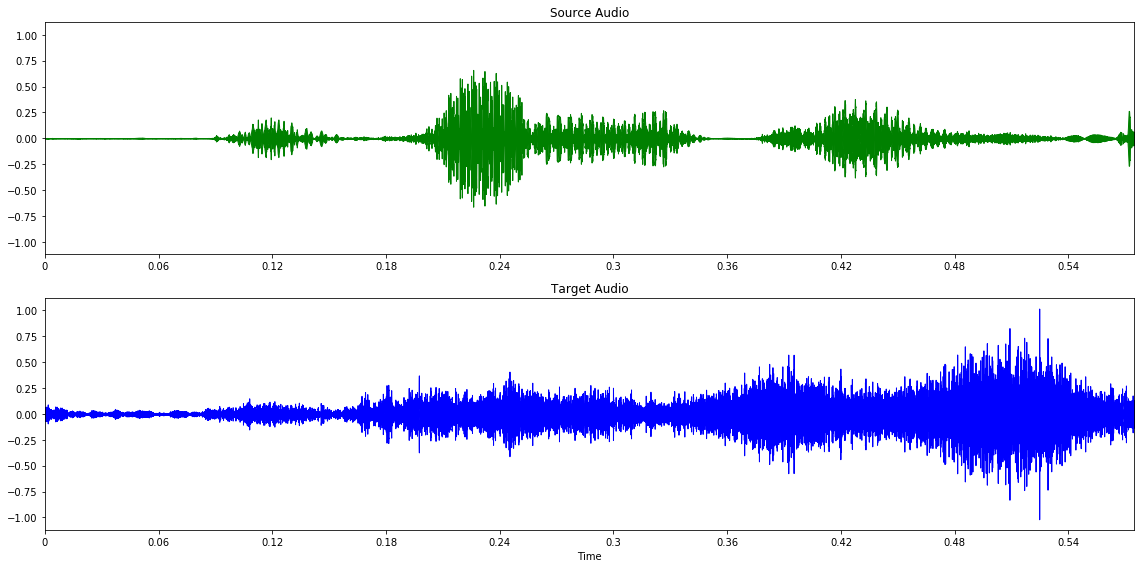

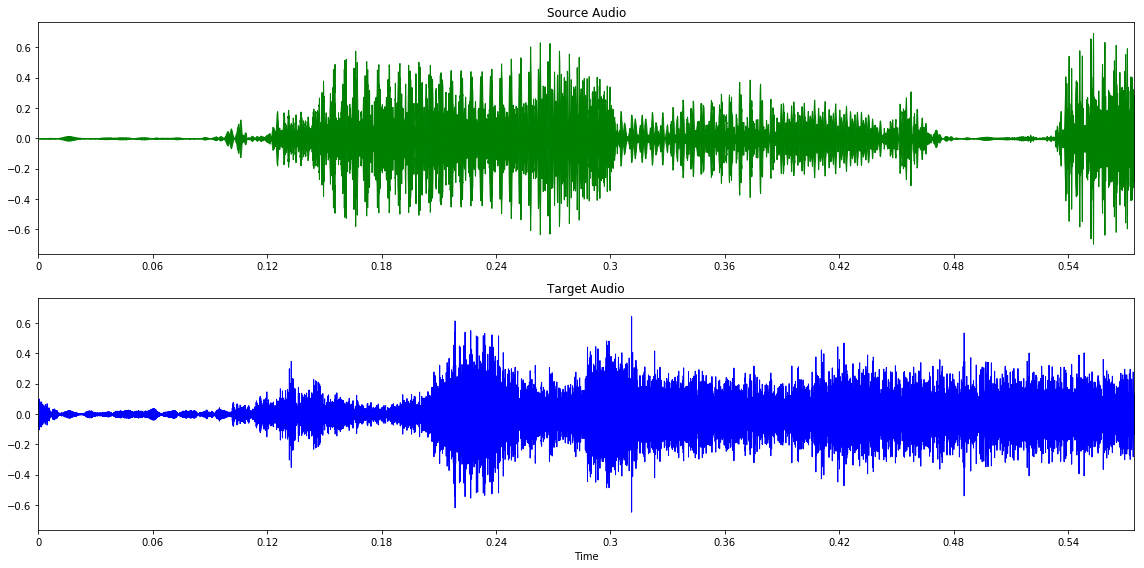

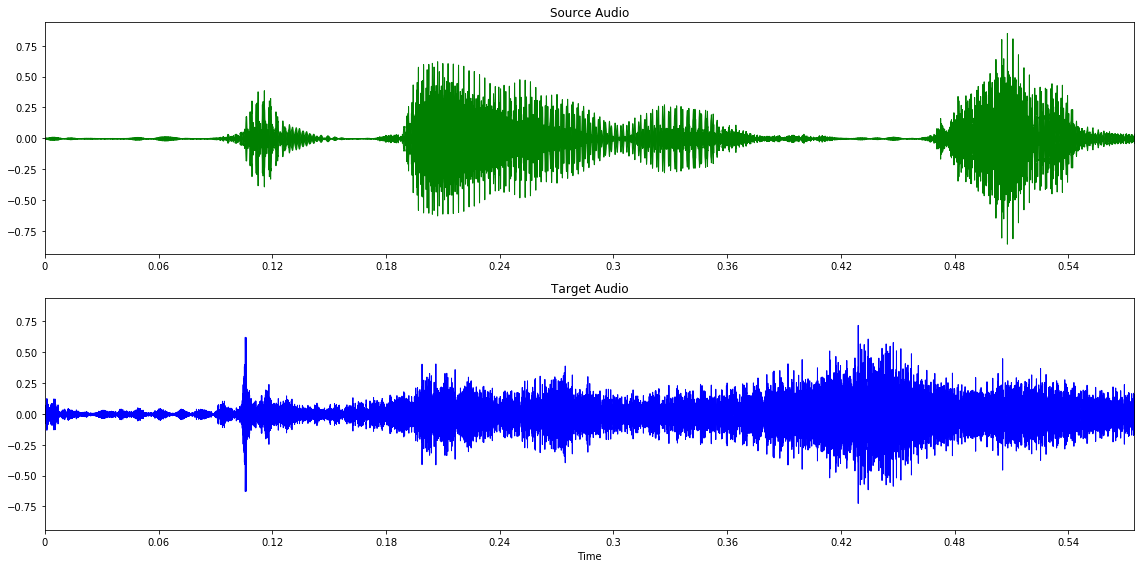

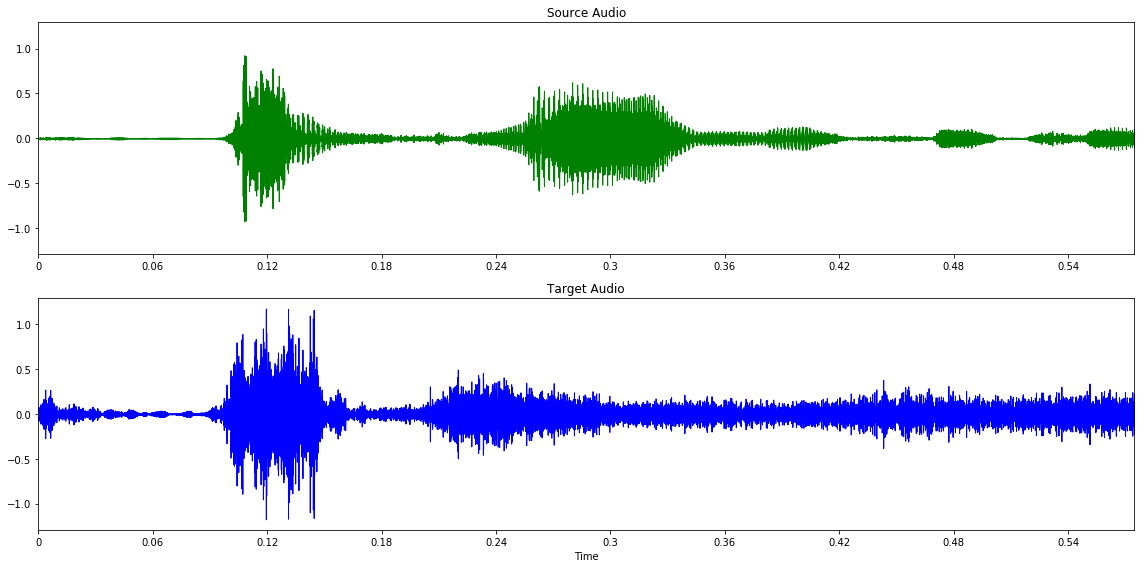

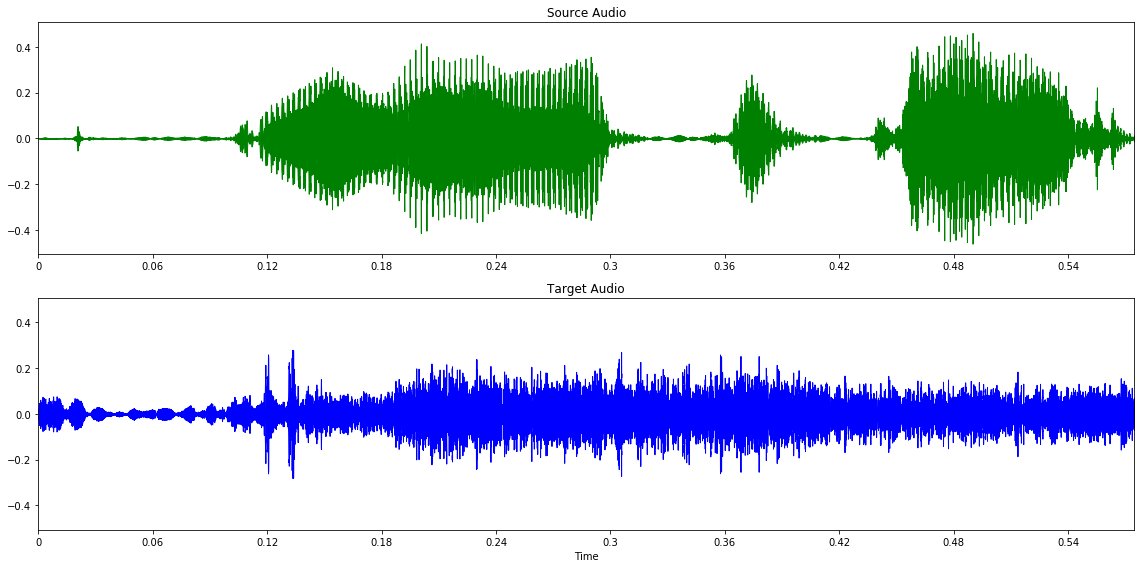

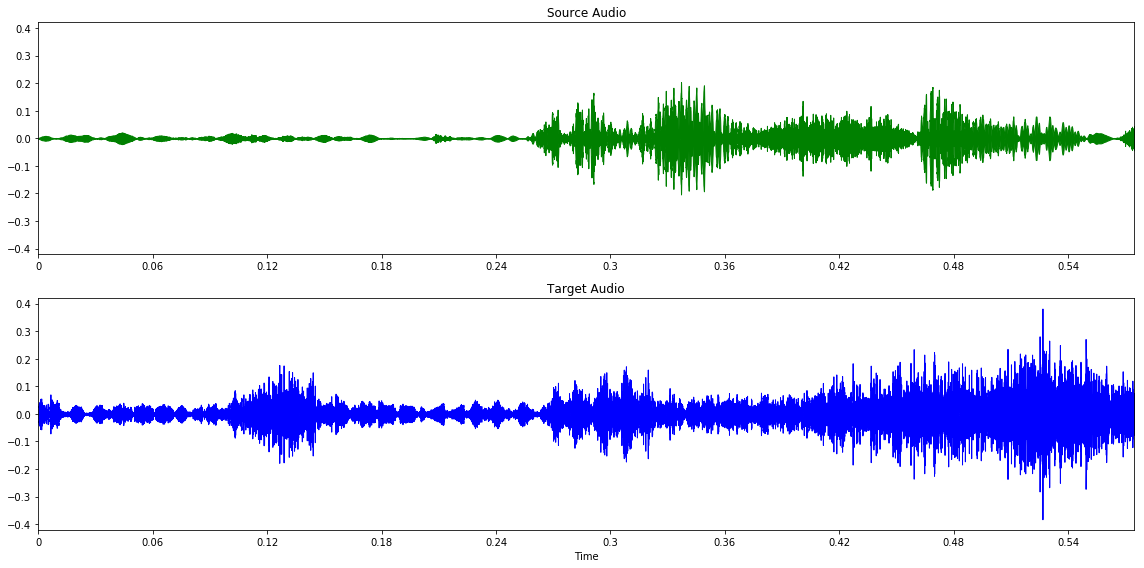

In [35]:
for i in range(len(data)):
    data_np = (data[i].to(torch.device("cpu"))).detach().numpy();
    data_np = librosa.db_to_amplitude(data_np)
    data_griffin_lim = librosa.griffinlim(data_np)
    data_recon_np = (data_recon[i].to(torch.device("cpu"))).detach().numpy();
    data_recon_np = librosa.db_to_amplitude(data_recon_np)
    data_recon_griffin_lim = librosa.griffinlim(data_recon_np)
    
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(2,1,1)
    output_path = '/home/ubuntu/speech2speech/test_num_embeddings256_spectrogram_db_lr1em4/plots/raw_plot_' + str(i) + '.png'
    source_aud_path = '/home/ubuntu/speech2speech/test_num_embeddings256_spectrogram_db_lr1em4/output/source_' + str(i) + '.wav'
    target_aud_path =  '/home/ubuntu/speech2speech/test_num_embeddings256_spectrogram_db_lr1em4/output/target_' + str(i) + '.wav'
    
    librosa.display.waveplot(data_griffin_lim, color = 'g')
    plt.title('Source Audio')
    plt.xlabel('')
    plt.subplot(2,1,2, sharex=ax, sharey=ax)
    plt.title('Target Audio')
    librosa.display.waveplot(5*data_recon_griffin_lim, color = 'b')
    plt.tight_layout()
    fig.savefig(output_path)
    
    librosa.output.write_wav(source_aud_path,data_griffin_lim, 16384)
    librosa.output.write_wav(target_aud_path,data_recon_griffin_lim, 16384)

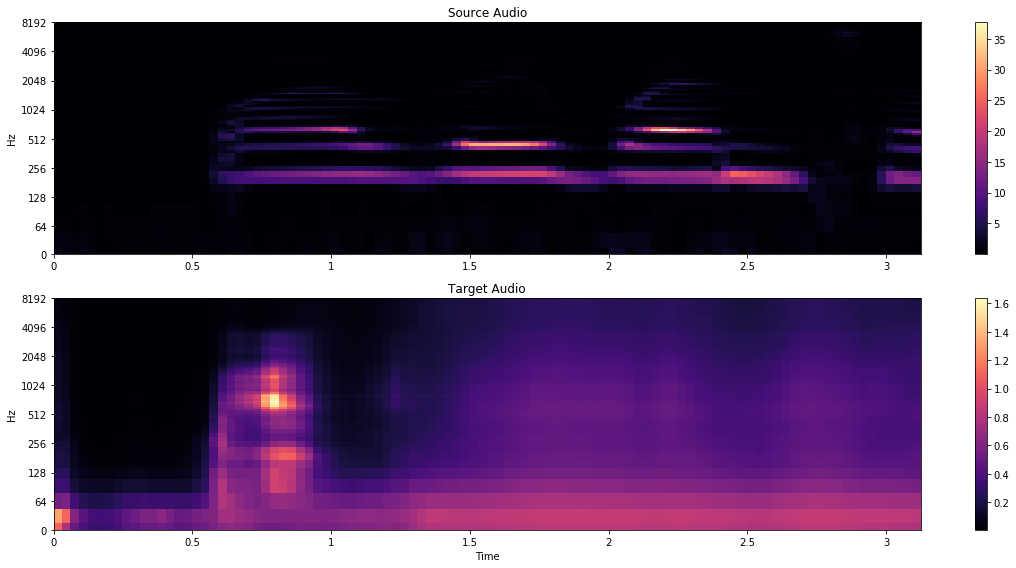

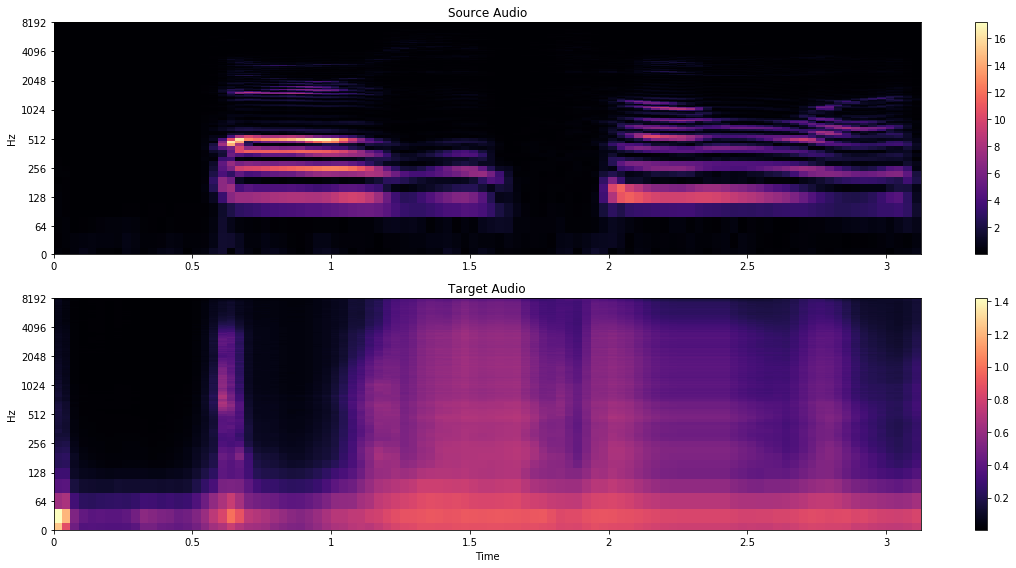

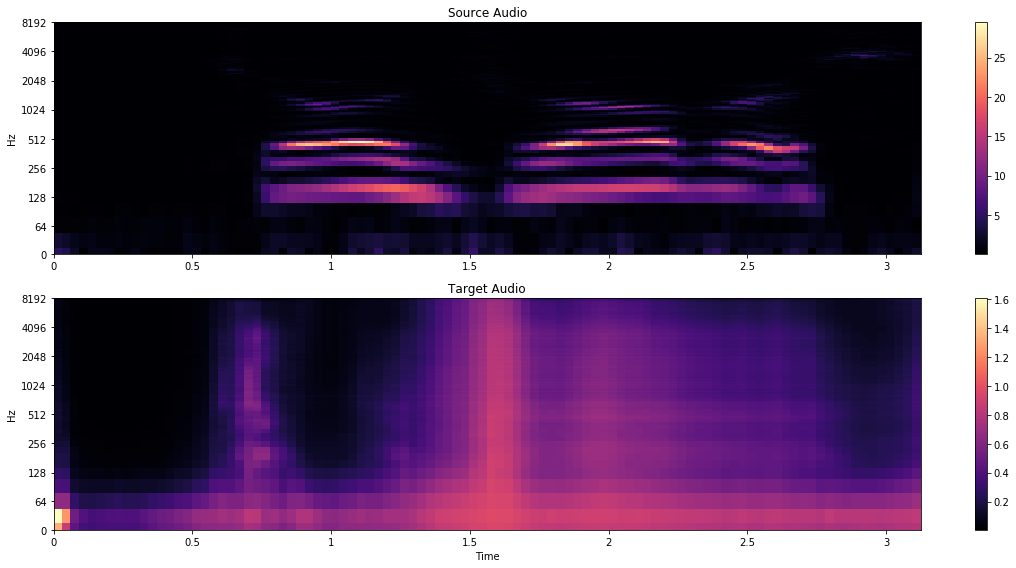

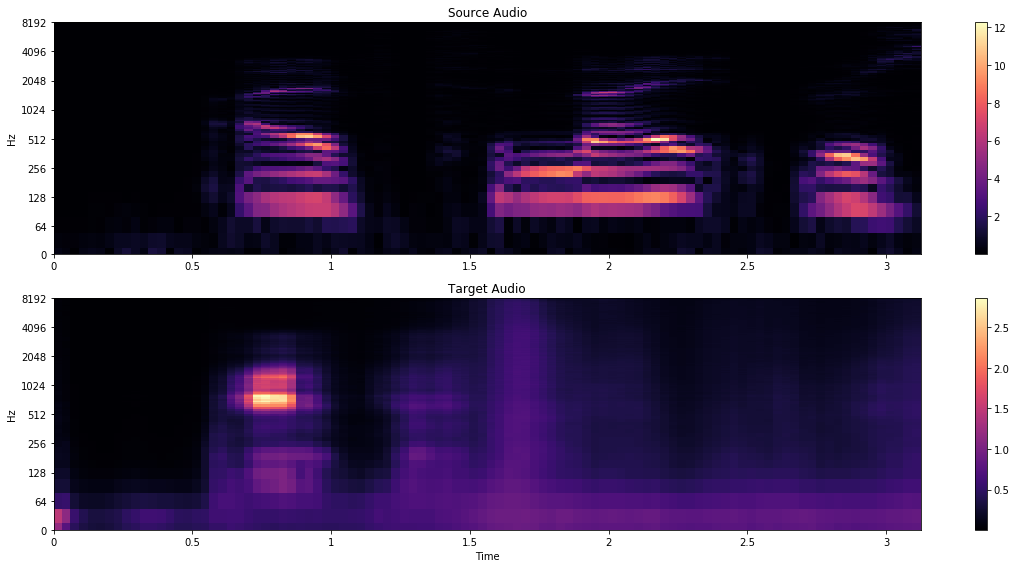

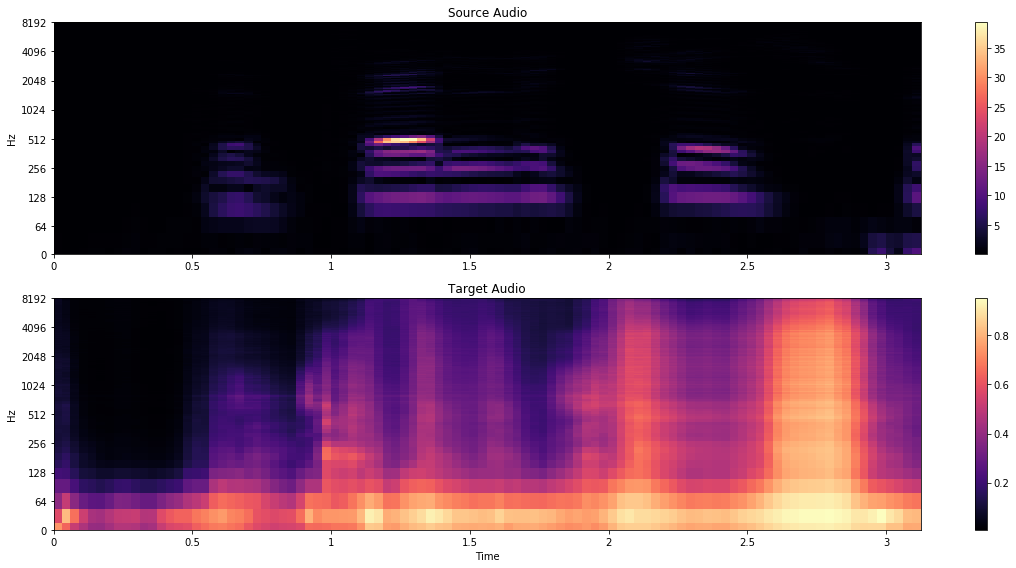

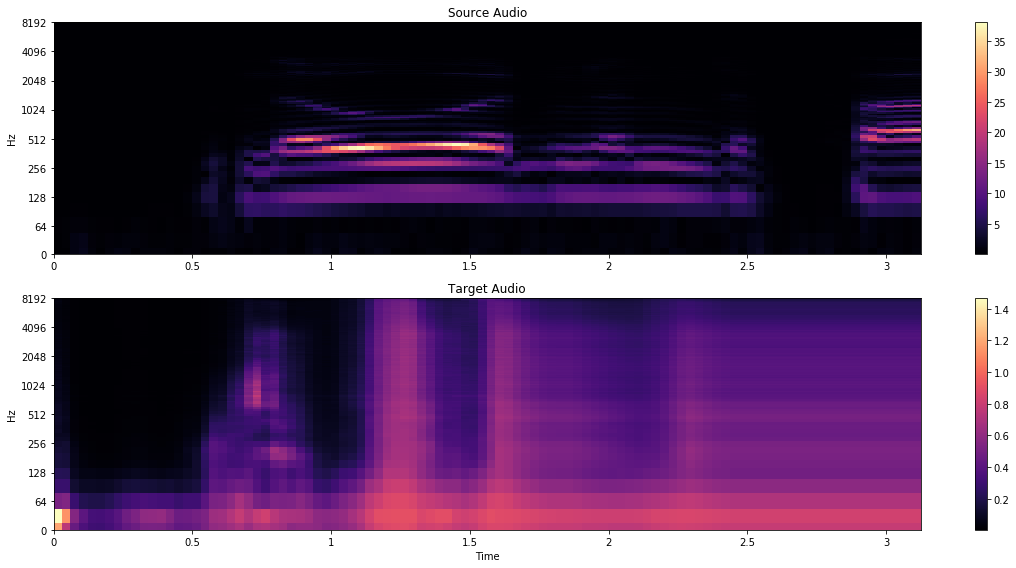

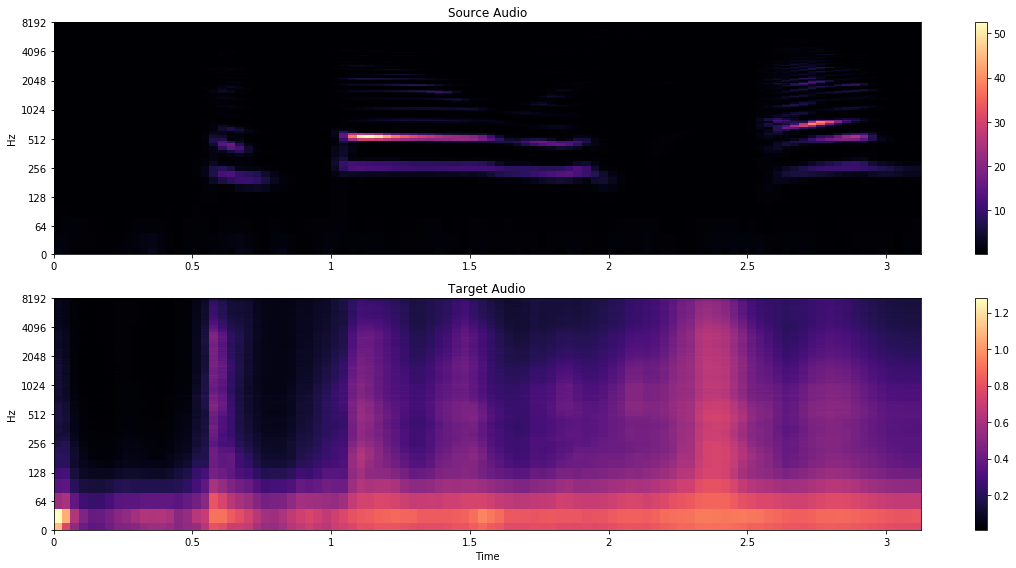

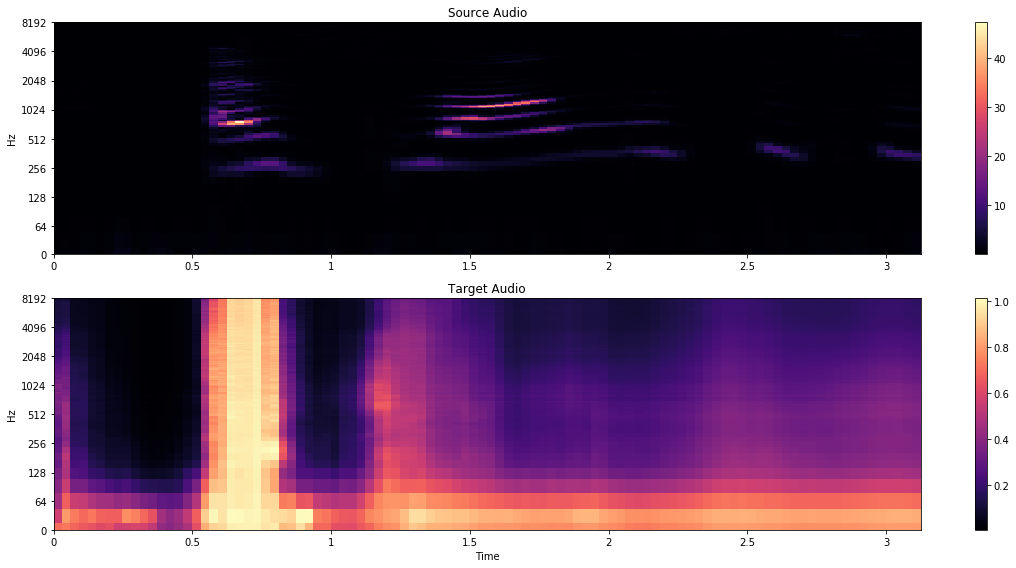

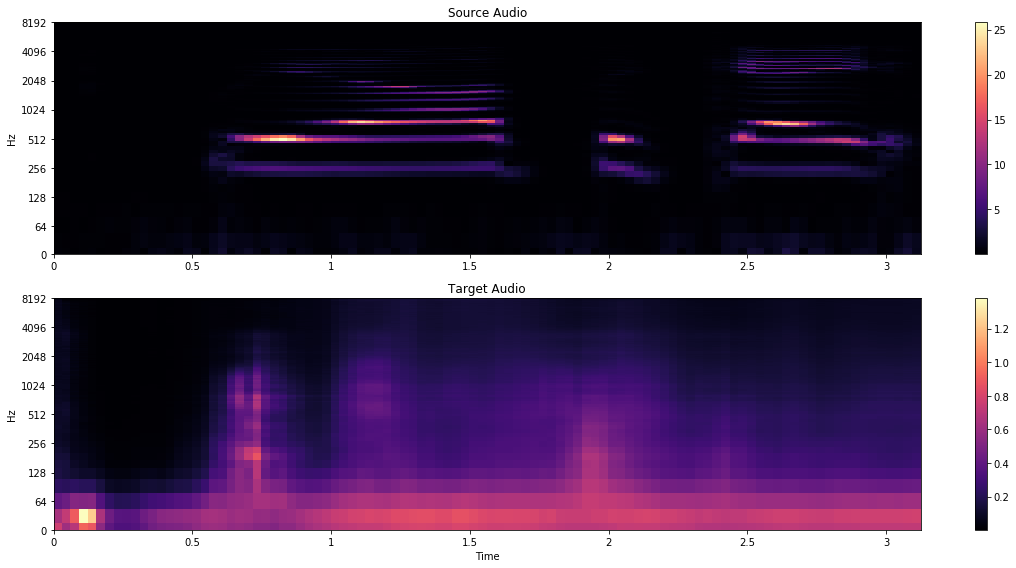

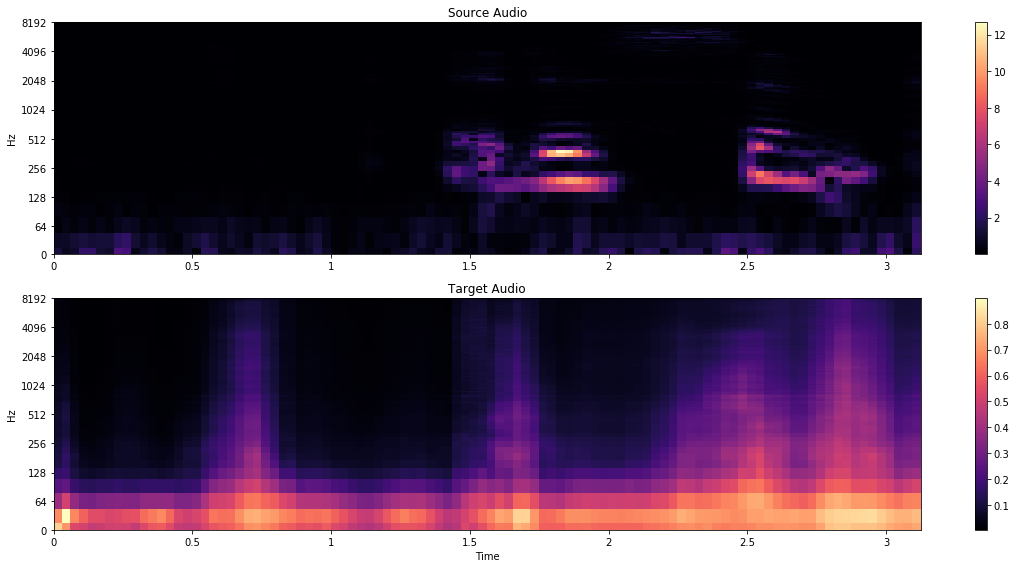

In [36]:
for i in range(len(data)):
    data_np = (data[i].to(torch.device("cpu"))).detach().numpy();
    data_np = librosa.db_to_amplitude(data_np)
    data_griffin_lim = librosa.griffinlim(data_np)
    data_recon_np = (data_recon[i].to(torch.device("cpu"))).detach().numpy();
    data_recon_np = librosa.db_to_amplitude(data_recon_np)
    data_recon_griffin_lim = librosa.griffinlim(data_recon_np)
    
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(2,1,1)
    output_path = '/home/ubuntu/speech2speech/test_num_embeddings256_spectrogram_db_lr1em4/plots/spec_plot_' + str(i) + '.png'

    librosa.display.specshow(data_np, sr=16384, x_axis='time', y_axis='log')
    plt.title('Source Audio')
    plt.xlabel('')
    plt.colorbar()
    plt.subplot(2,1,2, sharex=ax, sharey=ax)
    plt.title('Target Audio')
    librosa.display.specshow(data_recon_np, sr=16384, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.tight_layout()
    fig.savefig(output_path)

In [ ]:
# trying on a sample audio 

spectrograms_to_torch_dataset(files_np, time_length)

In [37]:
files_np = list(glob.glob(os.path.join(spectrogram_dir, '*.*')))

In [103]:
file_trial = '/home/ubuntu/speech2speech/data/interim/spectogram_array_trim_30db/p236_470.npy'

In [105]:
file_trial.split('/p')[1][:3]

'236'

In [39]:
files_np[0]

'/home/ubuntu/speech2speech/data/interim/spectogram_array_path_trim_30db_ntft_512/p236_470.npy'

In [43]:
def spectrograms_to_torch(file, max_col):
    """
    Generates torch tensors for the spectrogram array and return
    them as a dataset
    """
    load_x = np.load(file)
    x = np.zeros((load_x.shape[0], max_col), dtype=np.float32)
    c = min(max_col, load_x.shape[1])
    x[:load_x.shape[0], :c] = load_x[:, :c]
    x = torch.tensor(x, device='cpu').float()
    trial_y = file.split('trim_spec_p')[1][:3]
    trial_y = torch.tensor(int(trial_y), device='cpu').float()

    tensordataset = torch.utils.data.TensorDataset(x, trial_y)
    return tensordataset

In [91]:
file_hack = '/home/ubuntu/speech2speech/data/interim/spectogram_array_path_trim_30db_ntft_512/p260_001.npy'

In [92]:
load_x = np.load(file_hack)
x = np.zeros((load_x.shape[0], 100), dtype=np.float32)
c = min(100, load_x.shape[1])
x[:load_x.shape[0], :c] = load_x[:, :c]
x = torch.tensor(x, device='cpu').float()
trial_y = files_np[0].split('/p')[1][:3]
trial_y = torch.tensor(int(trial_y), device='cpu').float()

In [95]:
_, data_recon,_ = model(x.unsqueeze(0).to(device))

In [96]:
data_recon_np = (data_recon.squeeze(0).to(torch.device("cpu"))).detach().numpy();

In [88]:
data = x.unsqueeze(0).to(device)
data_np =(data.squeeze(0).to(torch.device("cpu"))).detach().numpy();
data_np = librosa.db_to_amplitude(data_np)
data_griffin_lim = librosa.griffinlim(data_np)

In [77]:
data_np

array([[[-11.0481825 ,  -2.492308  ,  -6.117251  , ...,  -6.0088725 ,
         -19.89568   , -32.60319   ],
        [ -6.7753572 ,  -0.47404262,  -1.8743734 , ...,  -3.4605303 ,
          -7.635973  ,  -8.206236  ],
        [ -0.5094196 ,  -2.7034352 ,  -6.5086217 , ...,  -7.3237424 ,
         -10.493069  ,  -8.469814  ],
        ...,
        [-44.45539   , -50.481983  , -51.140816  , ..., -51.140816  ,
         -51.140816  , -51.140816  ],
        [-44.485897  , -50.512566  , -51.140816  , ..., -51.140816  ,
         -51.140816  , -51.140816  ],
        [-44.49665   , -50.520668  , -51.140816  , ..., -51.140816  ,
         -51.140816  , -51.140816  ]]], dtype=float32)

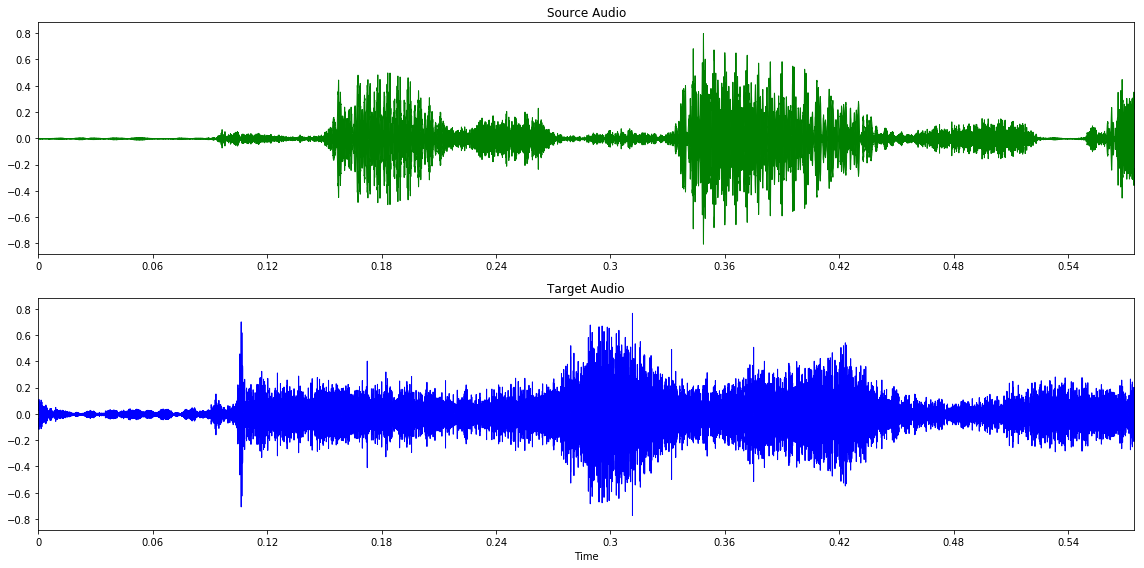

In [97]:
data = x.unsqueeze(0).to(device)
data_np =(data.squeeze(0).to(torch.device("cpu"))).detach().numpy();
data_np = librosa.db_to_amplitude(data_np)
data_griffin_lim = librosa.griffinlim(data_np)
data_recon_np = (data_recon.squeeze(0).to(torch.device("cpu"))).detach().numpy();
data_recon_np = librosa.db_to_amplitude(data_recon_np)
data_recon_griffin_lim = librosa.griffinlim(data_recon_np)
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(2,1,1)
#output_path = '/home/ubuntu/speech2speech/test_num_embeddings256_spectrogram_db_lr1em4/plots/raw_plot_' + str(i) + '.png'
#source_aud_path = '/home/ubuntu/speech2speech/test_num_embeddings256_spectrogram_db_lr1em4/output/source_' + str(i) + '.wav'
#target_aud_path =  '/home/ubuntu/speech2speech/test_num_embeddings256_spectrogram_db_lr1em4/output/target_' + str(i) + '.wav'
    
librosa.display.waveplot(data_griffin_lim, color = 'g')
plt.title('Source Audio')
plt.xlabel('')
plt.subplot(2,1,2, sharex=ax, sharey=ax)
plt.title('Target Audio')
librosa.display.waveplot(5*data_recon_griffin_lim, color = 'b')
plt.tight_layout()
fig.savefig(output_path)

In [143]:
model.eval() # enter evaluation mode
val_res_recon_error = []
train_res_perplexity = []
epoch_loss = 0
with torch.no_grad():
    for epoch in range(num_epochs):
        std, _ = std_mean_dataloader(validation_loader)
        for i, (x, _) in enumerate(validation_loader):
            batch_X = x.to(device)
            # forward pass
            vq_loss, data_recon, perplexity = model(batch_X)
            recon_error = F.mse_loss(data_recon, x.cuda()) / std
            loss = recon_error + vq_loss
            epoch_loss += loss.item()

            if (i+1) % 10 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], recon_error: {:.4f}, perplexity: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(training_loader), recon_error.item(), perplexity.item()))
                
        val_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())
        epoch_loss

Epoch[1/20], Step [10/3540], recon_error: 1.0074, perplexity: 11.1514
Epoch[1/20], Step [20/3540], recon_error: 0.7826, perplexity: 8.2006
Epoch[1/20], Step [30/3540], recon_error: 0.8856, perplexity: 9.9572
Epoch[1/20], Step [40/3540], recon_error: 1.2405, perplexity: 10.7006
Epoch[1/20], Step [50/3540], recon_error: 1.5537, perplexity: 12.6538
Epoch[1/20], Step [60/3540], recon_error: 0.7761, perplexity: 10.9095
Epoch[1/20], Step [70/3540], recon_error: 0.9391, perplexity: 11.9851
Epoch[1/20], Step [80/3540], recon_error: 0.9424, perplexity: 10.9733
Epoch[1/20], Step [90/3540], recon_error: 1.4172, perplexity: 14.9323
Epoch[1/20], Step [100/3540], recon_error: 1.2381, perplexity: 12.9405
Epoch[1/20], Step [110/3540], recon_error: 1.1825, perplexity: 11.6221
Epoch[1/20], Step [120/3540], recon_error: 1.2339, perplexity: 13.6039
Epoch[1/20], Step [130/3540], recon_error: 1.0449, perplexity: 10.7599
Epoch[1/20], Step [140/3540], recon_error: 1.0384, perplexity: 10.0622
Epoch[1/20], Step

Epoch[3/20], Step [300/3540], recon_error: 1.0436, perplexity: 8.6656
Epoch[3/20], Step [310/3540], recon_error: 0.9354, perplexity: 7.8121
Epoch[3/20], Step [320/3540], recon_error: 1.2266, perplexity: 14.5931
Epoch[3/20], Step [330/3540], recon_error: 0.9687, perplexity: 10.3562
Epoch[3/20], Step [340/3540], recon_error: 1.2561, perplexity: 11.6979
Epoch[3/20], Step [350/3540], recon_error: 1.1229, perplexity: 9.9681
Epoch[3/20], Step [360/3540], recon_error: 1.5171, perplexity: 12.8567
Epoch[3/20], Step [370/3540], recon_error: 1.2291, perplexity: 10.8598
Epoch[3/20], Step [380/3540], recon_error: 0.7588, perplexity: 9.1148
Epoch[3/20], Step [390/3540], recon_error: 1.2003, perplexity: 13.5682
Epoch[3/20], Step [400/3540], recon_error: 1.2946, perplexity: 10.7736
Epoch[3/20], Step [410/3540], recon_error: 1.8538, perplexity: 15.5671
Epoch[3/20], Step [420/3540], recon_error: 1.8751, perplexity: 12.1972
Epoch[3/20], Step [430/3540], recon_error: 0.8899, perplexity: 8.6812
Epoch[3/20]

Epoch[6/20], Step [150/3540], recon_error: 1.1061, perplexity: 11.3519
Epoch[6/20], Step [160/3540], recon_error: 1.7499, perplexity: 12.5489
Epoch[6/20], Step [170/3540], recon_error: 0.5830, perplexity: 9.0405
Epoch[6/20], Step [180/3540], recon_error: 1.0406, perplexity: 14.0528
Epoch[6/20], Step [190/3540], recon_error: 0.7007, perplexity: 9.5838
Epoch[6/20], Step [200/3540], recon_error: 1.1446, perplexity: 13.7666
Epoch[6/20], Step [210/3540], recon_error: 1.0301, perplexity: 10.0067
Epoch[6/20], Step [220/3540], recon_error: 1.1531, perplexity: 13.5757
Epoch[6/20], Step [230/3540], recon_error: 1.3126, perplexity: 14.2747
Epoch[6/20], Step [240/3540], recon_error: 0.8427, perplexity: 9.0798
Epoch[6/20], Step [250/3540], recon_error: 1.2208, perplexity: 11.1854
Epoch[6/20], Step [260/3540], recon_error: 0.8891, perplexity: 11.5413
Epoch[6/20], Step [270/3540], recon_error: 1.3554, perplexity: 17.9548
Epoch[6/20], Step [280/3540], recon_error: 0.7461, perplexity: 8.8158
Epoch[6/20

Epoch[8/20], Step [430/3540], recon_error: 1.1970, perplexity: 12.0988
Epoch[8/20], Step [440/3540], recon_error: 0.8360, perplexity: 10.8922
Epoch[9/20], Step [10/3540], recon_error: 1.3080, perplexity: 18.2184
Epoch[9/20], Step [20/3540], recon_error: 0.6662, perplexity: 7.9751
Epoch[9/20], Step [30/3540], recon_error: 0.8193, perplexity: 8.2363
Epoch[9/20], Step [40/3540], recon_error: 0.9717, perplexity: 11.5882
Epoch[9/20], Step [50/3540], recon_error: 1.0422, perplexity: 10.4335
Epoch[9/20], Step [60/3540], recon_error: 0.7909, perplexity: 15.2585
Epoch[9/20], Step [70/3540], recon_error: 0.7517, perplexity: 12.6264
Epoch[9/20], Step [80/3540], recon_error: 0.7097, perplexity: 10.9817
Epoch[9/20], Step [90/3540], recon_error: 0.9367, perplexity: 14.1036
Epoch[9/20], Step [100/3540], recon_error: 0.7146, perplexity: 11.6753
Epoch[9/20], Step [110/3540], recon_error: 0.8595, perplexity: 12.7711
Epoch[9/20], Step [120/3540], recon_error: 0.8894, perplexity: 14.9724
Epoch[9/20], Step

Epoch[11/20], Step [270/3540], recon_error: 0.6736, perplexity: 13.3055
Epoch[11/20], Step [280/3540], recon_error: 0.9800, perplexity: 10.1224
Epoch[11/20], Step [290/3540], recon_error: 1.0559, perplexity: 10.9141
Epoch[11/20], Step [300/3540], recon_error: 1.1079, perplexity: 12.3769
Epoch[11/20], Step [310/3540], recon_error: 0.8771, perplexity: 14.4799
Epoch[11/20], Step [320/3540], recon_error: 0.9392, perplexity: 14.7164
Epoch[11/20], Step [330/3540], recon_error: 1.0605, perplexity: 13.2506
Epoch[11/20], Step [340/3540], recon_error: 1.4940, perplexity: 18.9684
Epoch[11/20], Step [350/3540], recon_error: 1.2733, perplexity: 13.2377
Epoch[11/20], Step [360/3540], recon_error: 0.9582, perplexity: 13.5644
Epoch[11/20], Step [370/3540], recon_error: 0.9003, perplexity: 11.6169
Epoch[11/20], Step [380/3540], recon_error: 0.8123, perplexity: 11.0294
Epoch[11/20], Step [390/3540], recon_error: 0.9691, perplexity: 11.5931
Epoch[11/20], Step [400/3540], recon_error: 1.5248, perplexity: 

Epoch[14/20], Step [100/3540], recon_error: 0.9419, perplexity: 14.5174
Epoch[14/20], Step [110/3540], recon_error: 0.8986, perplexity: 15.1516
Epoch[14/20], Step [120/3540], recon_error: 0.6776, perplexity: 10.7455
Epoch[14/20], Step [130/3540], recon_error: 0.8660, perplexity: 8.1670
Epoch[14/20], Step [140/3540], recon_error: 1.1020, perplexity: 17.1495
Epoch[14/20], Step [150/3540], recon_error: 0.5873, perplexity: 9.4061
Epoch[14/20], Step [160/3540], recon_error: 1.2201, perplexity: 12.6459
Epoch[14/20], Step [170/3540], recon_error: 1.3076, perplexity: 17.3955
Epoch[14/20], Step [180/3540], recon_error: 1.0702, perplexity: 13.6005
Epoch[14/20], Step [190/3540], recon_error: 1.2282, perplexity: 15.9183
Epoch[14/20], Step [200/3540], recon_error: 1.0139, perplexity: 12.7227
Epoch[14/20], Step [210/3540], recon_error: 1.4331, perplexity: 14.2234
Epoch[14/20], Step [220/3540], recon_error: 0.9814, perplexity: 10.8603
Epoch[14/20], Step [230/3540], recon_error: 0.8983, perplexity: 11

Epoch[16/20], Step [370/3540], recon_error: 1.3506, perplexity: 11.7367
Epoch[16/20], Step [380/3540], recon_error: 1.0626, perplexity: 7.9368
Epoch[16/20], Step [390/3540], recon_error: 2.4652, perplexity: 23.3024
Epoch[16/20], Step [400/3540], recon_error: 1.0049, perplexity: 10.3895
Epoch[16/20], Step [410/3540], recon_error: 0.6989, perplexity: 7.5238
Epoch[16/20], Step [420/3540], recon_error: 0.8503, perplexity: 13.6545
Epoch[16/20], Step [430/3540], recon_error: 1.4853, perplexity: 14.1501
Epoch[16/20], Step [440/3540], recon_error: 0.9802, perplexity: 10.0671
Epoch[17/20], Step [10/3540], recon_error: 0.8019, perplexity: 13.0500
Epoch[17/20], Step [20/3540], recon_error: 0.8395, perplexity: 9.2950
Epoch[17/20], Step [30/3540], recon_error: 1.2855, perplexity: 17.4890
Epoch[17/20], Step [40/3540], recon_error: 0.9497, perplexity: 14.8400
Epoch[17/20], Step [50/3540], recon_error: 0.5603, perplexity: 10.6158
Epoch[17/20], Step [60/3540], recon_error: 1.0850, perplexity: 15.5925
E

Epoch[19/20], Step [200/3540], recon_error: 0.6727, perplexity: 11.3644
Epoch[19/20], Step [210/3540], recon_error: 1.0034, perplexity: 15.8768
Epoch[19/20], Step [220/3540], recon_error: 1.2657, perplexity: 18.2888
Epoch[19/20], Step [230/3540], recon_error: 0.7105, perplexity: 10.0833
Epoch[19/20], Step [240/3540], recon_error: 1.1862, perplexity: 10.1305
Epoch[19/20], Step [250/3540], recon_error: 1.2306, perplexity: 13.1193
Epoch[19/20], Step [260/3540], recon_error: 0.9241, perplexity: 11.9445
Epoch[19/20], Step [270/3540], recon_error: 0.5338, perplexity: 7.8062
Epoch[19/20], Step [280/3540], recon_error: 1.0244, perplexity: 10.2747
Epoch[19/20], Step [290/3540], recon_error: 1.0741, perplexity: 12.7084
Epoch[19/20], Step [300/3540], recon_error: 0.7081, perplexity: 8.7471
Epoch[19/20], Step [310/3540], recon_error: 0.9339, perplexity: 12.5307
Epoch[19/20], Step [320/3540], recon_error: 0.9246, perplexity: 11.6458
Epoch[19/20], Step [330/3540], recon_error: 1.4034, perplexity: 14

In [144]:
epoch_loss

12273.898899048567

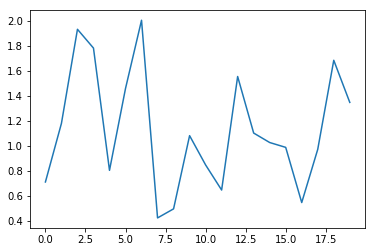

In [122]:
plt.plot(val_res_recon_error)

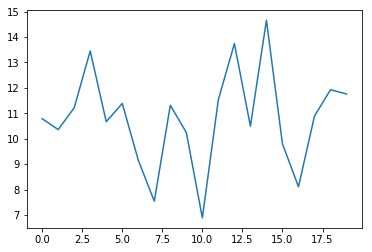

In [124]:
plt.plot(train_res_perplexity)

In [140]:
val_res_recon_error_smooth = savgol_filter(val_res_recon_error, 15, 4)
val_res_perplexity_smooth = savgol_filter(train_res_perplexity, 15, 4)

Text(0.5, 1.0, 'Smoothed Average codebook usage (perplexity).')

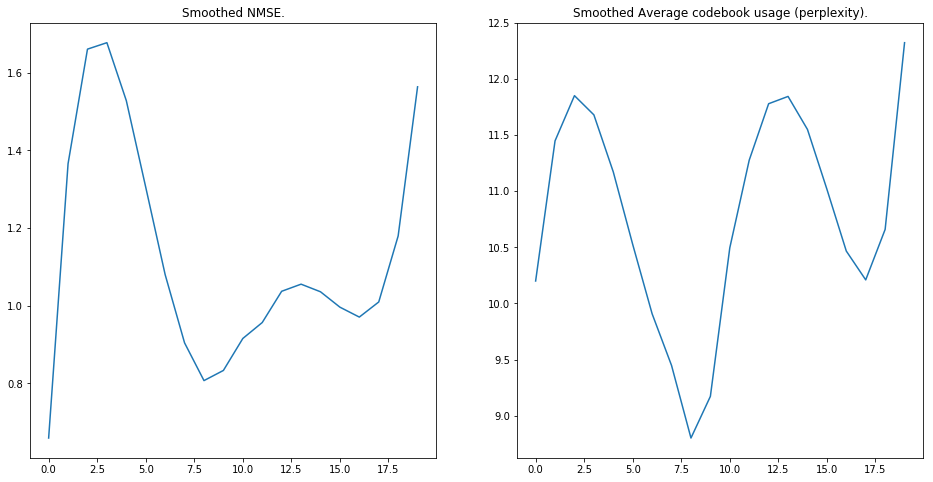

In [141]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(val_res_recon_error_smooth)
#ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax = f.add_subplot(1,2,2)
ax.plot(val_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')

In [127]:
len(val_res_recon_error)

20

In [142]:
optim.Adam?